<a href="https://colab.research.google.com/github/varisvithitpaiboon/Proactive-Customer-Experience-Management-Using-Predictive-Analytics-on-WiFi-Behavior-Data/blob/main/UCL_Lifemote_Predictive_Call_Autoencoder_anomaly_detection_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
!pip -q install optuna
!pip -q install catboost
!pip -q install tsfresh[dask]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
from datetime import timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, average_precision_score
from sklearn.model_selection import cross_val_score
import optuna
import shap
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import IPython.display as display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import gc
import tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import average_precision_score, ndcg_score
import stumpy
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Import data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Network Data

In [ ]:
# Set your folder path inside Google Drive
network_folder_path = '/content/drive/MyDrive/UCL-Lifemote/network_data'


chunksize = 50000  # Adjust based on available RAM

# List all CSV files in the folder
network_csv_files = [f for f in os.listdir(network_folder_path) if f.endswith('.csv')]

# Initialize an empty list to collect all chunks
dataframes = []

# Process files in chunks
for file in tqdm(network_csv_files, desc="Processing CSV files"):
    full_path = os.path.join(network_folder_path, file)
    try:
        chunk_iter = pd.read_csv(full_path, chunksize=chunksize)
        for i, chunk in enumerate(chunk_iter):
            chunk['source_file'] = file  # Optional: tag origin
            chunk['chunk_number'] = i    # Optional: track chunk
            dataframes.append(chunk)     # Store each chunk temporarily
    except Exception as e:
        print(f" Failed to load {file}: {e}")

# Combine all chunks into one DataFrame
if dataframes:
    df_network = pd.concat(dataframes, ignore_index=True)
    print(f" Final df_network shape: {df_network.shape}")
else:
    print(" No valid data was read from the folder.")


Processing CSV files: 100%|██████████| 30/30 [01:52<00:00,  3.73s/it]


 Final df_network shape: (13605240, 96)


In [ ]:
print(df_network['analysis_date'].unique())
print(df_network['analysis_date'].value_counts(dropna=False))

['2025-06-11 00:00:00' '2025-06-12 00:00:00' '2025-06-14 00:00:00'
 '2025-06-15 00:00:00' '2025-06-16 00:00:00' '2025-06-17 00:00:00'
 '2025-06-18 00:00:00' '2025-06-19 00:00:00' '2025-06-20 00:00:00'
 '2025-06-21 00:00:00' '2025-06-22 00:00:00' '2025-06-23 00:00:00'
 '2025-06-24 00:00:00' '2025-06-25 00:00:00' '2025-06-26 00:00:00'
 '2025-06-27 00:00:00' '2025-06-28 00:00:00' '2025-06-29 00:00:00'
 '2025-06-30 00:00:00' '2025-06-13 00:00:00' '2025-07-01 00:00:00'
 '2025-07-02 00:00:00' '2025-07-03 00:00:00' '2025-07-04 00:00:00'
 '2025-07-05 00:00:00' '2025-07-06 00:00:00' '2025-07-07 00:00:00'
 '2025-07-08 00:00:00' '2025-07-09 00:00:00' '2025-07-10 00:00:00']
analysis_date
2025-07-10 00:00:00    458053
2025-07-09 00:00:00    457649
2025-07-07 00:00:00    456972
2025-07-08 00:00:00    456894
2025-07-04 00:00:00    456205
2025-07-06 00:00:00    456075
2025-07-05 00:00:00    456067
2025-07-03 00:00:00    455628
2025-07-02 00:00:00    455247
2025-07-01 00:00:00    455055
2025-06-30 00:0

In [ ]:
df_network.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,mid_fwa_count,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number
0,DEVICE_ID_961c5550db,2025-06-11 00:00:00,ID_b0a43c9bc9,ANALYSIS_ID_e1e909f586,0,0,0,1878,2174,1853,...,0,14,1,0.0,0.0,NaN,41.55,0,cpe_status_2025-06-11_ready.csv,0
1,DEVICE_ID_39190265c2,2025-06-11 00:00:00,ID_5c687e45be,ANALYSIS_ID_05f8ccfe3e,0,0,0,2,2496,1,...,0,0,0,0.0,0.0,NaN,58.12,0,cpe_status_2025-06-11_ready.csv,0
2,DEVICE_ID_77a16a8d79,2025-06-11 00:00:00,ID_11db07b498,ANALYSIS_ID_8df4ed77df,0,0,0,0,818,0,...,0,0,0,0.0,0.0,NaN,39.60,0,cpe_status_2025-06-11_ready.csv,0
3,DEVICE_ID_905832b06c,2025-06-11 00:00:00,ID_393c580a22,ANALYSIS_ID_8ed247d1a2,0,0,0,1634,3787,1625,...,0,4,0,0.0,0.0,NaN,40.48,0,cpe_status_2025-06-11_ready.csv,0
4,DEVICE_ID_8f1dbe5a7f,2025-06-11 00:00:00,ID_67ec92db86,ANALYSIS_ID_55850a81fe,0,0,0,1488,1142,6,...,0,0,0,0.0,0.0,NaN,58.62,0,cpe_status_2025-06-11_ready.csv,0


## Import Call Data

In [ ]:
# Set your folder path inside Google Drive
call_file_path = '/content/drive/MyDrive/UCL-Lifemote/call_data/df_call_final.csv'

# Read the CSV file
df_call = pd.read_csv(call_file_path)

# Preview
print(f"df_call shape: {df_call.shape}")

df_call shape: (47355, 7)


In [ ]:
df_call.head()

,id,resource_id,created_at,user_id,group_name,username,resource
0,1094528,RESOURCE_ID_b1a07b8694,2025-06-11 02:34:53.355349,465,first-line,USERNAME_7cd244d515,home
1,1094529,RESOURCE_ID_072bdfd2f5,2025-06-11 02:34:54.344923,465,first-line,USERNAME_7cd244d515,cpe
2,1094530,RESOURCE_ID_aa2d955d4e,2025-06-11 02:34:54.400746,465,first-line,USERNAME_7cd244d515,cpe
3,1094531,RESOURCE_ID_b1a07b8694,2025-06-11 02:34:54.455219,465,first-line,USERNAME_7cd244d515,cpe
4,1094532,RESOURCE_ID_24e3e9b021,2025-06-11 02:34:54.726571,465,first-line,USERNAME_7cd244d515,cpe


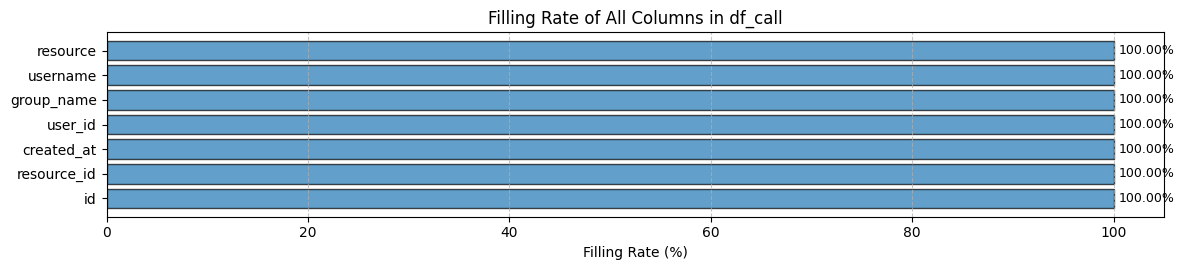

In [ ]:
# Calculate filling rates
filling_rates = 100 * df_call.count() / df_call.shape[0]
filling_rates = filling_rates.round(2)

# Sort for cleaner display
filling_rates_sorted = filling_rates.sort_values(ascending=True)

# Plot filling rate
plt.figure(figsize=(12, 0.4 * len(filling_rates_sorted)))

bars = plt.barh(
    filling_rates_sorted.index,
    filling_rates_sorted.values,
    color=['#1f77b4'],
    alpha=0.7,
    edgecolor='black'
)

# Add value labels on bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}%",
        va='center',
        fontsize=9
    )

# Axis and formatting
plt.xlabel("Filling Rate (%)")
plt.title("Filling Rate of All Columns in df_call")
plt.xlim(0, 105)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Data Preprocessing

## Label flag_call and ensure datetime format

In [ ]:
# Flag Call = 1
df_call["flag_call"] = 1

In [ ]:
# Ensure 'analysis_date' is in datetime format (normalized to midnight)
df_network['analysis_date'] = pd.to_datetime(df_network['analysis_date']).dt.normalize()

# Ensure 'created_at' is in datetime format (normalized to midnight)
df_call['created_at'] = pd.to_datetime(df_call['created_at']).dt.normalize()

# Preview values and types
print(df_network['analysis_date'].head())
print(df_call['created_at'].head())

0   2025-06-11
1   2025-06-11
2   2025-06-11
3   2025-06-11
4   2025-06-11
Name: analysis_date, dtype: datetime64[ns]
0   2025-06-11
1   2025-06-11
2   2025-06-11
3   2025-06-11
4   2025-06-11
Name: created_at, dtype: datetime64[ns]


## Extract device_id

In [ ]:
# Extract resource_id
df_call['resource_id'] = df_call['resource_id'].str[12:]
df_call['resource_id'].head(5)

# Count unique customer of df_call
print(f"Number of customers in df_call: {df_call['resource_id'].nunique()}")

Number of customers in df_call: 13401


In [ ]:
# Extract device_id
df_network['device_id'] = df_network['device_id'].str[10:]
df_network['device_id'].head(1)

# count unique customer of df_network
print(f"Number of cudtomers in df_network{df_network['device_id'].nunique()}")

Number of cudtomers in df_network475660


## Drop duplicate calls

In [ ]:
# Drop duplicate call on the same day
df_call = df_call.drop_duplicates(subset=['resource_id', 'created_at'], keep='first')
# df_call.head()
df_call.shape

(14924, 8)

In [ ]:
# Count how many customer_ids appear in both DataFrames
overlap_count = len(set(df_network['device_id']) & set(df_call['resource_id']))
print(f"Overlapping device_id & resource_id count: {overlap_count}")

## Merge df_network and df_call

In [ ]:
# Merge df_network and df_call
df_merged = df_network.merge(
    df_call[['resource_id','group_name', 'resource', 'created_at', 'flag_call']],
    how='left',
    left_on=['device_id', 'analysis_date'],
    right_on=['resource_id', 'created_at']
)

# Fill missing flag_call values with 0
df_merged['flag_call'] = df_merged['flag_call'].fillna(0).astype(int)

# Result
df_merged.tail(100)

# Clear RAM
del df_network
del df_call

gc.collect()

0

In [ ]:
# Count positive and negative flag_call values
call_counts = df_merged['flag_call'].value_counts().sort_index()

# Print results
print(" Flag Call Counts:")
print(f"Negative (0): {call_counts.get(0, 0)}")
print(f"Positive (1): {call_counts.get(1, 0)}")

del call_counts

gc.collect()

 Flag Call Counts:
Negative (0): 13595193
Positive (1): 10047


0

In [ ]:
df_merged.head()

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,resource_id,group_name,resource,created_at,flag_call
0,961c5550db,2025-06-11,ID_b0a43c9bc9,ANALYSIS_ID_e1e909f586,0,0,0,1878,2174,1853,...,NaN,41.55,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
1,39190265c2,2025-06-11,ID_5c687e45be,ANALYSIS_ID_05f8ccfe3e,0,0,0,2,2496,1,...,NaN,58.12,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
2,77a16a8d79,2025-06-11,ID_11db07b498,ANALYSIS_ID_8df4ed77df,0,0,0,0,818,0,...,NaN,39.60,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
3,905832b06c,2025-06-11,ID_393c580a22,ANALYSIS_ID_8ed247d1a2,0,0,0,1634,3787,1625,...,NaN,40.48,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
4,8f1dbe5a7f,2025-06-11,ID_67ec92db86,ANALYSIS_ID_55850a81fe,0,0,0,1488,1142,6,...,NaN,58.62,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0


In [ ]:
df_merged

,device_id,analysis_date,id,analysis_id,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,...,channel_changes_count_6,mem_usage,high_mem_usage_samples,source_file,chunk_number,resource_id,group_name,resource,created_at,flag_call
0,961c5550db,2025-06-11,ID_b0a43c9bc9,ANALYSIS_ID_e1e909f586,0,0,0,1878,2174,1853,...,NaN,41.55,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
1,39190265c2,2025-06-11,ID_5c687e45be,ANALYSIS_ID_05f8ccfe3e,0,0,0,2,2496,1,...,NaN,58.12,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
2,77a16a8d79,2025-06-11,ID_11db07b498,ANALYSIS_ID_8df4ed77df,0,0,0,0,818,0,...,NaN,39.60,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
3,905832b06c,2025-06-11,ID_393c580a22,ANALYSIS_ID_8ed247d1a2,0,0,0,1634,3787,1625,...,NaN,40.48,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
4,8f1dbe5a7f,2025-06-11,ID_67ec92db86,ANALYSIS_ID_55850a81fe,0,0,0,1488,1142,6,...,NaN,58.62,0,cpe_status_2025-06-11_ready.csv,0,NaN,NaN,NaN,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13605235,12ca7ad469,2025-07-10,ID_6012931456,ANALYSIS_ID_dfd92999b1,0,0,0,1439,2814,1438,...,NaN,56.81,0,cpe_status_2025-07-10_ready.csv,9,NaN,NaN,NaN,NaT,0
13605236,8c73fd16b2,2025-07-10,ID_0dd30f864f,ANALYSIS_ID_ad3cdb02a5,0,0,1,294,5817,238,...,NaN,21.37,0,cpe_status_2025-07-10_ready.csv,9,NaN,NaN,NaN,NaT,0
13605237,2871b13069,2025-07-10,ID_71dce99f39,ANALYSIS_ID_3c0dcab5a1,0,0,0,3828,7620,3677,...,NaN,42.78,0,cpe_status_2025-07-10_ready.csv,9,NaN,NaN,NaN,NaT,0
13605238,fc95d7b1b2,2025-07-10,ID_d3f1eb691a,ANALYSIS_ID_2cff5e191d,0,0,1,806,4165,750,...,NaN,26.22,0,cpe_status_2025-07-10_ready.csv,9,NaN,NaN,NaN,NaT,0


In [ ]:
df_merged.shape

(13605240, 101)

In [ ]:
# Select Sample devices to run the model, whle keeping proportion of fault positive similar to original dataset
def sample_complete_devices(df, target_devices=20_000, call_col='flag_call', date_col='analysis_date', random_state=42):
    # Calculate original proportions
    original_row_ratio = df[call_col].mean()
    device_status = df.groupby('device_id')[call_col].mean().gt(0)
    original_device_ratio = device_status.mean()

    print(f"Original row call ratio: {original_row_ratio:.5f}")
    print(f"Original device call ratio: {original_device_ratio:.5f}")

    # Get complete devices (all dates present)
    n_dates = df[date_col].nunique()
    complete_devices = (df.groupby('device_id')[date_col]
                       .nunique()
                       .loc[lambda x: x == n_dates]
                       .index)
    df_complete = df[df['device_id'].isin(complete_devices)]

    # Classify complete devices
    device_status = df_complete.groupby('device_id')[call_col].mean().gt(0)
    call_devices = device_status[device_status].index
    healthy_devices = device_status[~device_status].index

    # Calculate required samples (with safeguards)
    n_fcall = int(round(target_devices * original_device_ratio))
    n_call = min(n_fcall, len(call_devices))
    n_healthy = target_devices - n_call

    # Adjust if healthy devices are insufficient
    if n_healthy > len(healthy_devices):
        n_healthy = len(healthy_devices)
        n_call = target_devices - n_healthy

    # Sample devices (allow replacement if needed)
    np.random.seed(random_state)
    replace_call = n_call > len(call_devices)
    replace_healthy = n_healthy > len(healthy_devices)
    sampled_call = np.random.choice(call_devices, n_call, replace=replace_call)
    sampled_healthy = np.random.choice(healthy_devices, n_healthy, replace=replace_healthy)

    # Combine sampled devices
    sampled_devices = np.concatenate([sampled_call, sampled_healthy])
    df_sampled = df_complete[df_complete['device_id'].isin(sampled_devices)]

    # Downsample call rows to match original ratio (optional)
    current_row_ratio = df_sampled[call_col].mean()
    if current_row_ratio > 0:
        scale_factor = original_row_ratio / current_row_ratio
        if scale_factor < 1:
            call_rows = df_sampled[df_sampled[call_col] == 1]
            keep_prob = min(scale_factor, 1.0)
            mask = np.random.random(len(call_rows)) < keep_prob
            df_sampled = pd.concat([
                df_sampled[df_sampled[call_col] == 0],
                call_rows[mask]
            ])

    # Verification
    verification = {
        'total_devices': df_sampled['device_id'].nunique(),
        'call_devices': len(sampled_call),
        'row_call_ratio': df_sampled[call_col].mean(),
        'device_call_ratio': (df_sampled.groupby('device_id')[call_col].mean() > 0).mean(),
        'date_completeness': (df_sampled.groupby('device_id')[date_col].nunique() == n_dates).all(),
        'total_rows': len(df_sampled)
    }

    print("\n=== Results ===")
    print(f"Sampled devices: {verification['total_devices']} (target: {target_devices})")
    print(f"Call devices: {verification['call_devices']}")
    print(f"Achieved row call ratio: {verification['row_call_ratio']:.5f}")
    print(f"Device call ratio: {verification['device_call_ratio']:.5f}")
    print(f"All dates present: {verification['date_completeness']}")
    print(f"Total rows: {verification['total_rows']}")

    return df_sampled

In [ ]:
df_sampled = sample_complete_devices(df_merged)

Original row call ratio: 0.00074
Original device call ratio: 0.01865

=== Results ===
Sampled devices: 20000 (target: 20000)
Call devices: 373
Achieved row call ratio: 0.00071
Device call ratio: 0.01865
All dates present: True
Total rows: 600000


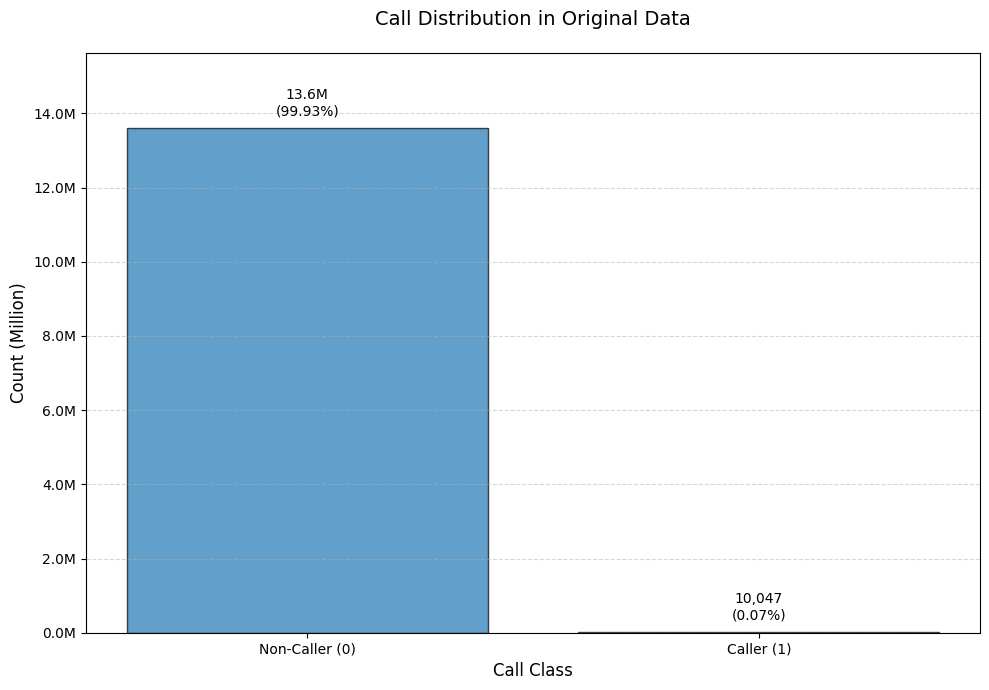

In [ ]:
# Plot of df_merged Original
counts = df_merged['flag_call'].value_counts().sort_index()
percentages = (counts / len(df_merged) * 100).round(2)

plt.figure(figsize=(10, 7))
bars = plt.bar(counts.index, counts.values,
               color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

# Add count and percentage labels
for bar, count, percent in zip(bars, counts, percentages):
    height = bar.get_height()
    label = f"{count/1e6:.1f}M\n({percent}%)" if count >= 1e6 else f"{count:,}\n({percent}%)"
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02 * max(counts),
             label,
             ha='center', va='bottom', fontsize=10)

# Customize y-axis to show millions
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.title('Call Distribution in Original Data', pad=20, fontsize=14)
plt.xlabel('Call Class', fontsize=12)
plt.ylabel('Count (Million)', fontsize=12)
plt.xticks([0, 1], ['Non-Caller (0)', 'Caller (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, max(counts) * 1.15)
plt.tight_layout()
plt.show()

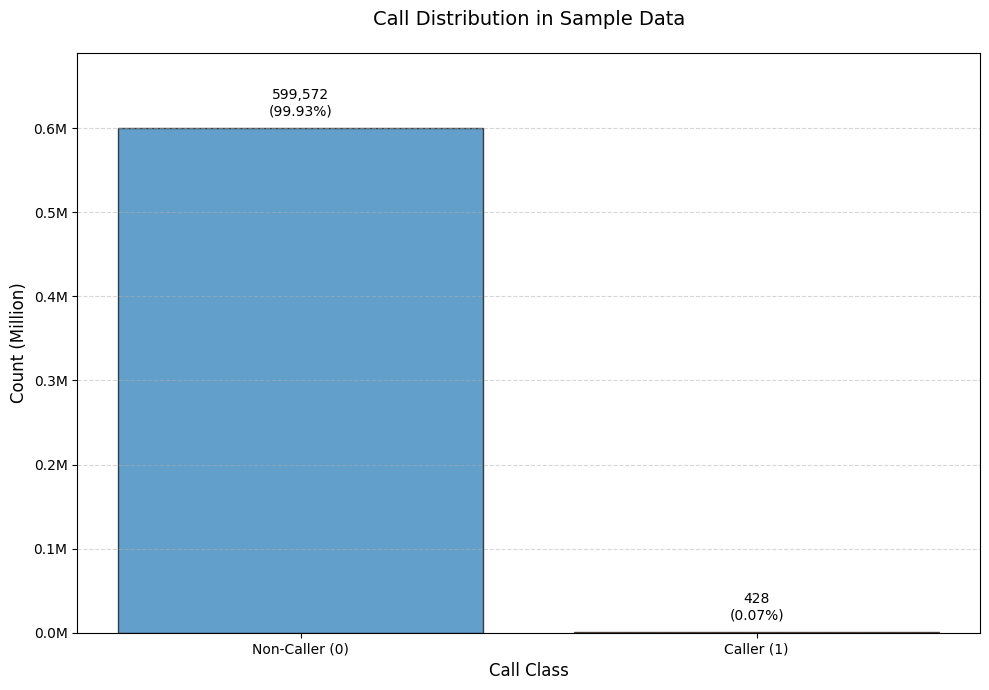

In [ ]:
# Plot for df_merged Sample
counts = df_sampled['flag_call'].value_counts().sort_index()
percentages = (counts / len(df_sampled) * 100).round(2)

plt.figure(figsize=(10, 7))
bars = plt.bar(counts.index, counts.values,
               color=['#1f77b4', '#ff7f0e'], alpha=0.7, edgecolor='black')

# Add count and percentage labels
for bar, count, percent in zip(bars, counts, percentages):
    height = bar.get_height()
    label = f"{count/1e6:.1f}M\n({percent}%)" if count >= 1e6 else f"{count:,}\n({percent}%)"
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02 * max(counts),
             label,
             ha='center', va='bottom', fontsize=10)

# Customize y-axis to show millions
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

plt.title('Call Distribution in Sample Data', pad=20, fontsize=14)
plt.xlabel('Call Class', fontsize=12)
plt.ylabel('Count (Million)', fontsize=12)
plt.xticks([0, 1], ['Non-Caller (0)', 'Caller (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, max(counts) * 1.15)
plt.tight_layout()
plt.show()

In [ ]:
# Reassign
df_merged = df_sampled

del df_sampled

gc.collect()

32

# Data Cleaning

In [ ]:
# Drop rows with missing flag_call
original_len = len(df_merged)

df_merged = df_merged.dropna(subset=['flag_call']).reset_index(drop=True)

print(f"Removed {original_len - len(df_merged)} rows with missing flag_call")

del original_len

gc.collect()

Removed 0 rows with missing flag_call


2722

In [ ]:
# Check which columns are completely empty (all values are NaN)
empty_columns = df_merged.columns[df_merged.isnull().all()].tolist()

# Print result
if empty_columns:
    print(f"Number of rows and columns: {df_merged.shape}")
    print(f"Number of empty columns: {len(empty_columns)}")
    print(f"Empty column names: {(empty_columns)}")
else:
    print("No empty columns")

Number of rows and columns: (600000, 101)
Number of empty columns: 11
Empty column names: ['cpu_temp', 'dsl_status', 'greedy_status', 'dsl_connection_stability_status', 'dsl_rate_stability_status', 'congestion_6_status', 'wifi_standard_24', 'wifi_standard_5', 'wifi_standard_6', 'fwa_quality_status', 'channel_changes_count_6']


In [ ]:
del empty_columns

gc.collect()

0

In [ ]:
# Drop NaN columns
df_merged = df_merged.dropna(axis=1, how='all')
print(f"Number of rows and columns: {df_merged.shape}")

Number of rows and columns: (600000, 90)


In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 2 decimal places
filling_rates = filling_rates.round(2)

# Identify columns with < 50% filled
low_fill_columns = filling_rates[filling_rates < 50].index.tolist()

# Drop those columns
df_merged = df_merged.drop(columns=low_fill_columns)

# Print summary
print(f"Dropped {len(low_fill_columns)}")
print(f"low-filling columns (<50% filled): {low_fill_columns}")
print(f"New shape: {df_merged.shape}")

del filling_rates
del low_fill_columns

gc.collect()

Dropped 7
low-filling columns (<50% filled): ['legacy_status', 'repeater_status', 'max_outage_time', 'resource_id', 'group_name', 'resource', 'created_at']
New shape: (600000, 83)


0

In [ ]:
# List of columns to keep even if they have constant values
columns_to_keep = ['analysis_date', 'flag_call']

# Identify constant columns excluding the ones to keep
constant_columns = [
    col for col in df_merged.columns
    if df_merged[col].nunique(dropna=False) == 1 and col not in columns_to_keep
]

# Drop those columns
df_merged = df_merged.drop(columns=constant_columns)

# Print summary
print(f"Dropped {len(constant_columns)}")
print(f"constant columns: {constant_columns}")

del columns_to_keep
del constant_columns

gc.collect()

Dropped 20
constant columns: ['dsl_download_bottleneck_count', 'dsl_upload_bottleneck_count', 'interfered_active_samples_24', 'interfered_samples_24', 'greedy_event_count', 'wifi_bottleneck_count', 'poor_greedy_event_count', 'total_samples_6', 'poor_samples_6', 'mid_samples_6', 'good_samples_6', 'total_active_samples_6', 'poor_active_samples_6', 'mid_active_samples_6', 'good_active_samples_6', 'sample_active_6_count', 'congested_sample_6_count', 'congested_sample_active_6_count', 'poor_fwa_count', 'mid_fwa_count']


0

In [ ]:
# Drop irrelavant columns
irrelevant_columns = ['source_file', 'id', 'analysis_id']

# Drop those columns
df_merged = df_merged.drop(columns=irrelevant_columns)

# Print summary
print(f"Dropped {len(irrelevant_columns)}")
print(f"New shape: {df_merged.shape}")

del irrelevant_columns

gc.collect()

Dropped 3
New shape: (600000, 60)


0

In [ ]:
# Calculate percentage of non-null values for each column
filling_rates = 100 * df_merged.count() / df_merged.shape[0]

# Round to 4 decimal places
filling_rates = filling_rates.round(4)

# Filter and sort columns with less than 100% filled
incomplete_columns = filling_rates[filling_rates < 100].sort_values(ascending=False)

# Print the result
if not incomplete_columns.empty:
    print("Columns with less than 100% non-null values (ascending):")
    print(incomplete_columns)
    print(len(incomplete_columns))

    # Calculate and print the number of missing rows for each incomplete column
    print("\nNumber of missing rows per incomplete column:")
    missing_counts = df_merged[incomplete_columns.index].isnull().sum()
    print(missing_counts)
else:
    print("All columns are 100% complete.")

Columns with less than 100% non-null values (ascending):
channel_changes_count_24             99.8690
channel_changes_count_5              99.8627
congestion_24_status                 99.8590
congestion_5_status                  99.8527
wifi_coverage_status                 97.2568
wifi_coverage_5_status               94.5172
poor_gw_candidate_rssi_samples_24    92.7900
poor_gw_candidate_rssi_samples_5     92.7900
wifi_qoe_status                      91.5580
wifi_coverage_24_status              84.7537
dtype: float64
10

Number of missing rows per incomplete column:
channel_changes_count_24               786
channel_changes_count_5                824
congestion_24_status                   846
congestion_5_status                    884
wifi_coverage_status                 16459
wifi_coverage_5_status               32897
poor_gw_candidate_rssi_samples_24    43260
poor_gw_candidate_rssi_samples_5     43260
wifi_qoe_status                      50652
wifi_coverage_24_status              9147

## Clean missing rows using backward fill

In [ ]:
# Sort analysis_date and device_id
df_merged = df_merged.sort_values(['device_id', 'analysis_date'])

# Define columns that need to be fill
columns_to_fill = incomplete_columns.index

# Backward Fill
for col in columns_to_fill:
    df_merged[col] = df_merged.groupby('device_id')[col].transform('bfill')

# Report how many values are still missing
missing_summary = df_merged[columns_to_fill].isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("All missing values filled successfully.")
else:
    print("Remaining missing values after fill:")
    print(missing_summary)

Remaining missing values after fill:
channel_changes_count_24               765
channel_changes_count_5                775
congestion_24_status                   825
congestion_5_status                    835
wifi_coverage_status                  8453
wifi_coverage_5_status               16021
poor_gw_candidate_rssi_samples_24    43260
poor_gw_candidate_rssi_samples_5     43260
wifi_qoe_status                      16739
wifi_coverage_24_status              29280
dtype: int64


In [ ]:
del incomplete_columns
del filling_rates
del columns_to_fill
del missing_summary

gc.collect()

0

In [ ]:
# Count missing rows before dropping
missing_rows = df_merged.shape[0] - df_merged.dropna().shape[0]

# Drop missing rows
df_merged = df_merged.dropna()

# Print summary
print(f"Dropped {missing_rows} rows with missing values")
print(f"New shape: {df_merged.shape}")

del missing_rows

gc.collect()

Dropped 80545 rows with missing values
New shape: (519455, 60)


0

In [ ]:
# Sort by time
df_merged = df_merged.sort_values('analysis_date')
print(df_merged['analysis_date'])

2692     2025-06-11
15260    2025-06-11
7661     2025-06-11
5019     2025-06-11
3630     2025-06-11
            ...    
599426   2025-07-10
597941   2025-07-10
594071   2025-07-10
584107   2025-07-10
585984   2025-07-10
Name: analysis_date, Length: 519455, dtype: datetime64[ns]


In [ ]:
# Count positive and negative flag_call values
call_counts = df_merged['flag_call'].value_counts().sort_index()

# Print results
print(" Flag Call Counts:")
print(f"Negative (0): {call_counts.get(0, 0)}")
print(f"Positive (1): {call_counts.get(1, 0)}")

del call_counts

gc.collect()

 Flag Call Counts:
Negative (0): 519137
Positive (1): 318


0

# Feature Engineering - Predict Wifi Fault

## Ordinal Encoder

In [ ]:
# Ensure the column is string type
df_merged['congestion_5_status'] = df_merged['congestion_5_status'].astype(str)
df_merged['congestion_24_status'] = df_merged['congestion_24_status'].astype(str)
df_merged['band_usage_24_status'] = df_merged['band_usage_24_status'].astype(str)
df_merged['wifi_qoe_status'] = df_merged['wifi_qoe_status'].astype(str)

# # Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'GOOD']])

# Apply ordinal encoding
df_merged['congestion_5_status'] = encoder.fit_transform(df_merged[['congestion_5_status']])
df_merged['congestion_24_status'] = encoder.fit_transform(df_merged[['congestion_24_status']])
df_merged['band_usage_24_status'] = encoder.fit_transform(df_merged[['band_usage_24_status']])
df_merged['wifi_qoe_status'] = encoder.fit_transform(df_merged[['wifi_qoe_status']])


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status', 'wifi_qoe_status']]

,congestion_5_status,congestion_24_status,band_usage_24_status,wifi_qoe_status
2692,2.0,2.0,2.0,2.0
15260,2.0,1.0,2.0,0.0
7661,0.0,1.0,2.0,1.0
5019,0.0,2.0,2.0,2.0
3630,2.0,2.0,2.0,2.0
...,...,...,...,...
599426,2.0,2.0,2.0,2.0
597941,2.0,2.0,2.0,2.0
594071,2.0,2.0,2.0,2.0
584107,2.0,1.0,1.0,2.0


In [ ]:
df_merged[['congestion_5_status', 'congestion_24_status', 'band_usage_24_status', 'wifi_qoe_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 519455 entries, 2692 to 585984
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   congestion_5_status   519455 non-null  float64
 1   congestion_24_status  519455 non-null  float64
 2   band_usage_24_status  519455 non-null  float64
 3   wifi_qoe_status       519455 non-null  float64
dtypes: float64(4)
memory usage: 19.8 MB


In [ ]:
# Ensure the column is string type
df_merged['wifi_coverage_status'] = df_merged['wifi_coverage_status'].astype(str)
df_merged['wifi_coverage_24_status'] = df_merged['wifi_coverage_24_status'].astype(str)
df_merged['wifi_coverage_5_status'] = df_merged['wifi_coverage_5_status'].astype(str)

# Define the order of categories
encoder = OrdinalEncoder(categories=[['POOR', 'MID', 'HIGH']])

# Apply ordinal encoding
df_merged['wifi_coverage_status'] = encoder.fit_transform(df_merged[['wifi_coverage_status']])
df_merged['wifi_coverage_24_status'] = encoder.fit_transform(df_merged[['wifi_coverage_24_status']])
df_merged['wifi_coverage_5_status'] = encoder.fit_transform(df_merged[['wifi_coverage_5_status']])

In [ ]:
# Check data types for encoding columns
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 519455 entries, 2692 to 585984
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wifi_coverage_status     519455 non-null  float64
 1   wifi_coverage_24_status  519455 non-null  float64
 2   wifi_coverage_5_status   519455 non-null  float64
dtypes: float64(3)
memory usage: 15.9 MB


In [ ]:
df_merged[['wifi_coverage_status', 'wifi_coverage_24_status', 'wifi_coverage_5_status']]

,wifi_coverage_status,wifi_coverage_24_status,wifi_coverage_5_status
2692,2.0,2.0,1.0
15260,0.0,1.0,0.0
7661,2.0,2.0,2.0
5019,2.0,1.0,1.0
3630,2.0,0.0,2.0
...,...,...,...
599426,1.0,2.0,1.0
597941,2.0,2.0,2.0
594071,0.0,0.0,2.0
584107,2.0,2.0,2.0


In [ ]:
df_merged.shape

(519455, 60)

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,total_samples_24_non_iot,band_usage_24_status,poor_iot_weighted_samples_24,poor_active_iot_weighted_samples_24,channel_changes_count_24,channel_changes_count_5,mem_usage,high_mem_usage_samples,chunk_number,flag_call
2692,0005970190,2025-06-11,0,0,0,368,1557,351,1311,11,...,368,2.0,0,0,0.0,0.0,57.21,0,1,0
15260,ab7f2270de,2025-06-11,0,0,0,70,3634,55,2081,142,...,70,2.0,0,0,0.0,0.0,59.47,0,6,0
7661,ab8b015600,2025-06-11,0,0,0,2850,7610,1882,5625,56,...,2850,2.0,0,0,0.0,0.0,52.19,0,3,0
5019,ab8dc0e35c,2025-06-11,0,0,0,3105,10386,231,10286,43,...,3105,2.0,9,1,0.0,0.0,25.17,0,2,0
3630,188a7fa684,2025-06-11,0,0,0,27,2001,5,1715,0,...,27,2.0,2,0,0.0,0.0,69.78,0,1,0


## Ensure device_id exist across all dates

In [ ]:
# Filter device_id that exist across all dates
def filter_devices_with_complete_dates(df, device_col='device_id', date_col='analysis_date'):

    # Ensure datetime format ---
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Get all unique dates in the dataset ---
    all_dates = np.sort(df[date_col].unique())
    n_dates = len(all_dates)
    print(f" Total unique dates in dataset: {n_dates}")

    # Count unique dates per device ---
    device_date_counts = df.groupby(device_col)[date_col].nunique()

    # Identify complete devices ---
    complete_devices = device_date_counts[device_date_counts == n_dates].index
    n_complete = len(complete_devices)
    print(f" Found {n_complete} devices with complete date coverage (out of {len(device_date_counts)})")

    # Filter the DataFrame ---
    df_complete = df[df[device_col].isin(complete_devices)].copy()

    # Verify result ---
    remaining_devices = df_complete[device_col].nunique()
    assert remaining_devices == n_complete, " Filtering failed — counts don't match!"
    print(f" Final DataFrame contains {remaining_devices} devices with full date coverage")

    return df_complete

In [ ]:
df_merged = filter_devices_with_complete_dates(df_merged)

print(f' df_merged shape {df_merged.shape}')

 Total unique dates in dataset: 30
 Found 14799 devices with complete date coverage (out of 17904)
 Final DataFrame contains 14799 devices with full date coverage
 df_merged shape (443970, 60)


## Manual Feature Engineering

In [ ]:
# Create Manual Ferature Engineering
def manual_feature_engineering(df):
    # df = df.copy()

    # Ratios
    df['poor_coverage_ratio_24'] = df['poor_samples_24'] / (df['total_active_samples_24'] + 1e-6)
    df['poor_coverage_ratio_5'] = df['poor_samples_5'] / (df['total_active_samples_5'] + 1e-6)
    df['poor_coverage_ratio_total'] = (df['poor_samples_5'] + df['poor_samples_24']) / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    df['active_poor_ratio_24'] = df['poor_active_samples_24'] / (df['total_active_samples_24'] + 1e-6)
    df['active_poor_ratio_5'] = df['poor_active_samples_5'] / (df['total_active_samples_5'] + 1e-6)
    df['active_poor_ratio_total'] = (df['poor_active_samples_24'] + df['poor_active_samples_5']) / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    df['total_stations_per_hour'] = df['number_of_wifi_clients'] / (df['uptime_in_minutes'] / 60 + 1e-6)

    # -Band preference and congestion ratios
    df['congestion_ratio_24'] = df['congested_sample_24_count'] / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)
    df['congestion_ratio_5'] = df['congested_sample_5_count'] / (df['total_active_samples_24'] + df['total_active_samples_5'] + 1e-6)

    return df


In [ ]:
df_merged = manual_feature_engineering(df_merged)

In [ ]:
df_merged.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,flag_call,poor_coverage_ratio_24,poor_coverage_ratio_5,poor_coverage_ratio_total,active_poor_ratio_24,active_poor_ratio_5,active_poor_ratio_total,total_stations_per_hour,congestion_ratio_24,congestion_ratio_5
2692,0005970190,2025-06-11,0,0,0,368,1557,351,1311,11,...,0,0.000000,0.077093,0.050725,0.000000,0.037445,0.024638,0.110571,0.001449,0.000000
15260,ab7f2270de,2025-06-11,0,0,0,70,3634,55,2081,142,...,0,0.000000,0.983854,0.962105,0.000000,0.541442,0.529474,0.011102,0.732632,0.002105
7661,ab8b015600,2025-06-11,0,0,0,2850,7610,1882,5625,56,...,0,0.000000,0.002020,0.001364,0.000000,0.000000,0.000000,0.006389,0.047749,0.107776
5019,ab8dc0e35c,2025-06-11,0,0,0,3105,10386,231,10286,43,...,0,0.087379,0.004241,0.010920,0.009709,0.000000,0.000780,0.405742,0.007800,0.017161
47,ab8df22c51,2025-06-11,1,0,0,0,110,0,109,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.465031,0.000000,0.000000


## Lag Features

In [ ]:
# Generated 1-day lag features
def add_top_lag_features(df, group_col='device_id', target_col='flag_call',
                         n_features=20, lag_period=1, verbose=True):

    # Identify numeric columns (excluding target)
    numeric_cols = df.select_dtypes(include='number').columns.difference([target_col])

    # Compute lag features
    lag_suffix = f'.lag{lag_period}'
    df_lagged = df.groupby(group_col)[numeric_cols].shift(lag_period).add_suffix(lag_suffix)

    # Compute correlations
    cor_df = df_lagged.copy()
    cor_df[target_col] = df[target_col].values
    correlations = cor_df.corr()[target_col].drop(target_col)

    # Select top N features
    top_features = correlations.abs().nlargest(n_features)
    top_lag_cols = top_features.index.tolist()

    # Merge top features with original data
    df_output = pd.concat([df, df_lagged[top_lag_cols]], axis=1)

    if verbose:
        print(f"\nTop {n_features} lag-{lag_period} correlated features with {target_col}:")
        for col in top_lag_cols:
            print(f"{col:.<30} correlation = {correlations[col]:.4f}")
        print(f"\nAdded {len(top_lag_cols)} lag features to DataFrame")

    return df_output, correlations

In [ ]:
df_merged, correlations = add_top_lag_features(df_merged)


Top 20 lag-1 correlated features with flag_call:
reboots.lag1.................. correlation = 0.0154
regular_update_drop_count.lag1 correlation = 0.0152
total_stations_per_hour.lag1.. correlation = 0.0145
channel_changes_count_5.lag1.. correlation = 0.0137
congestion_5_status.lag1...... correlation = -0.0135
sum_outage_time.lag1.......... correlation = 0.0110
congested_sample_5_count.lag1. correlation = 0.0104
outage_event_count.lag1....... correlation = 0.0068
uptime_in_minutes.lag1........ correlation = -0.0063
good_samples_5.lag1........... correlation = -0.0054
congested_sample_active_5_count.lag1 correlation = 0.0050
firmware_upgrades.lag1........ correlation = 0.0049
band_usage_24_status.lag1..... correlation = -0.0049
rssi_samples_5.lag1........... correlation = -0.0047
total_samples_5.lag1.......... correlation = -0.0047
total_active_samples_5.lag1... correlation = -0.0046
sample_active_5_count.lag1.... correlation = -0.0045
good_active_samples_5.lag1.... correlation = -0.0043

In [ ]:
df_merged['analysis_date'].unique()

<DatetimeArray>
['2025-06-11 00:00:00', '2025-06-12 00:00:00', '2025-06-13 00:00:00',
 '2025-06-14 00:00:00', '2025-06-15 00:00:00', '2025-06-16 00:00:00',
 '2025-06-17 00:00:00', '2025-06-18 00:00:00', '2025-06-19 00:00:00',
 '2025-06-20 00:00:00', '2025-06-21 00:00:00', '2025-06-22 00:00:00',
 '2025-06-23 00:00:00', '2025-06-24 00:00:00', '2025-06-25 00:00:00',
 '2025-06-26 00:00:00', '2025-06-27 00:00:00', '2025-06-28 00:00:00',
 '2025-06-29 00:00:00', '2025-06-30 00:00:00', '2025-07-01 00:00:00',
 '2025-07-02 00:00:00', '2025-07-03 00:00:00', '2025-07-04 00:00:00',
 '2025-07-05 00:00:00', '2025-07-06 00:00:00', '2025-07-07 00:00:00',
 '2025-07-08 00:00:00', '2025-07-09 00:00:00', '2025-07-10 00:00:00']
Length: 30, dtype: datetime64[ns]

## Create rolling delta featrues

In [ ]:
# Create day over day deltas od selected features
def compute_rolling_deltas(df, date_col='analysis_date', group_col='device_id'):

    # Sort by device and time
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([group_col, date_col])

    # Define base variables
    base_vars = [
        "reboots", "script_boots", "ap_count", "total_samples_24", "total_samples_5",
        "good_samples_24", "good_samples_5", "poor_qoe_samples_24",
        "poor_iot_weighted_samples_24", "channel_changes_count_24",
        "mem_usage", "high_mem_usage_samples"
    ]

    # Add wildcard-matched variables
    pattern_vars = df.columns[df.columns.str.contains("congested_sample_|poor_coverage_ratio_")].tolist()

    all_vars = base_vars + pattern_vars

    # Compute deltas per group
    for var in all_vars:
        if var in df.columns:
            delta_col = f'delta_{var}'
            df[delta_col] = df.groupby(group_col)[var].diff()

    return df


In [ ]:
# Apply the delta computation
df_merged = compute_rolling_deltas(df_merged)

In [ ]:
# Drop rows with ANY NaN values
df_merged = df_merged.dropna(how='any')

## Slice the data into train/validate/test

In [ ]:
df_merged['analysis_date'].nunique()

28

In [ ]:
df_merged['analysis_date'].sort_values()
print(df_merged['analysis_date'].unique())

<DatetimeArray>
['2025-06-13 00:00:00', '2025-06-14 00:00:00', '2025-06-15 00:00:00',
 '2025-06-16 00:00:00', '2025-06-17 00:00:00', '2025-06-18 00:00:00',
 '2025-06-19 00:00:00', '2025-06-20 00:00:00', '2025-06-21 00:00:00',
 '2025-06-22 00:00:00', '2025-06-23 00:00:00', '2025-06-24 00:00:00',
 '2025-06-25 00:00:00', '2025-06-26 00:00:00', '2025-06-27 00:00:00',
 '2025-06-28 00:00:00', '2025-06-29 00:00:00', '2025-06-30 00:00:00',
 '2025-07-01 00:00:00', '2025-07-02 00:00:00', '2025-07-03 00:00:00',
 '2025-07-04 00:00:00', '2025-07-05 00:00:00', '2025-07-06 00:00:00',
 '2025-07-07 00:00:00', '2025-07-08 00:00:00', '2025-07-09 00:00:00',
 '2025-07-10 00:00:00']
Length: 28, dtype: datetime64[ns]


In [ ]:
# Slice data into train/validate/test set according to days
def slice_time_based_sets(df, train_days=22, val_days=3, test_days=3):
    df = df.copy()
    df['analysis_date'] = pd.to_datetime(df['analysis_date'])
    start_date = df['analysis_date'].min()

    train_cutoff = start_date + timedelta(days=train_days - 1)
    val_cutoff = train_cutoff + timedelta(days=val_days)

    df_train = df[df['analysis_date'] <= train_cutoff]
    df_val = df[(df['analysis_date'] > train_cutoff) & (df['analysis_date'] <= val_cutoff)]
    df_test = df[df['analysis_date'] > val_cutoff]

    return df_train, df_val, df_test

In [ ]:
# Print Time-based slicing
df_train, df_val, df_test = slice_time_based_sets(df_merged)

print(f' df_train shape {df_train.shape}')
print(f' df_val shape {df_val.shape}')
print(f' df_test shape {df_test.shape}')

 df_train shape (325578, 109)
 df_val shape (44397, 109)
 df_test shape (44397, 109)


In [ ]:
print(df_train['analysis_date'].nunique())
print(df_val['analysis_date'].nunique())
print(df_test['analysis_date'].nunique())

22
3
3


In [ ]:
df_train['flag_call'].sum()

np.int64(184)

## Balance the df_train

In [ ]:
# Identify total number of unique dates
expected_days = df_train["analysis_date"].nunique()
print(f" Total unique dates: {expected_days}")

# Select all device_ids with at least one call (positive class)
positive_ids = df_train[df_train["flag_call"] == 1]["device_id"].unique()
df_positive = df_train[df_train["device_id"].isin(positive_ids)].copy()

# Filter positive devices with full date coverage
pos_date_counts = df_positive.groupby("device_id")["analysis_date"].nunique()
valid_positive_ids = pos_date_counts[pos_date_counts == expected_days].index
df_positive = df_positive[df_positive["device_id"].isin(valid_positive_ids)].copy()
print(f" Positive devices with full coverage: {df_positive['device_id'].nunique()}")

# Select negative device_ids (never called)
all_ids = df_train["device_id"].unique()
negative_ids = np.setdiff1d(all_ids, positive_ids)
df_negative = df_train[df_train["device_id"].isin(negative_ids)].copy()

# Filter negative devices with full date coverage
neg_date_counts = df_negative.groupby("device_id")["analysis_date"].nunique()
valid_negative_ids = neg_date_counts[neg_date_counts == expected_days].index
df_negative = df_negative[df_negative["device_id"].isin(valid_negative_ids)].copy()
print(f" Negative devices with full coverage: {df_negative['device_id'].nunique()}")

# Sample negative devices 5 times of positive devices
n_pos = df_positive["device_id"].nunique()
sampled_neg_ids = np.random.choice(valid_negative_ids, size=n_pos * 5, replace=False)
df_negative_sampled = df_negative[df_negative["device_id"].isin(sampled_neg_ids)].copy()
print(f" Sampled negative devices: {df_negative_sampled['device_id'].nunique()}")

# Merge positive and sampled negative data
df_train_balanced = pd.concat([df_positive, df_negative_sampled], ignore_index=True)
df_train_balanced = df_train_balanced.sort_values(["device_id", "analysis_date"])
print(f" Final balanced dataset shape: {df_train_balanced.shape}")

del expected_days
del positive_ids
del df_positive
del pos_date_counts
del valid_positive_ids
del all_ids
del negative_ids
del df_negative
del neg_date_counts
del valid_negative_ids
del n_pos
del sampled_neg_ids
del df_negative_sampled

gc.collect()

 Total unique dates: 22
 Positive devices with full coverage: 163
 Negative devices with full coverage: 14636
 Sampled negative devices: 815
 Final balanced dataset shape: (21516, 109)


9

In [ ]:
print("Train Sample:", df_train_balanced['flag_call'].value_counts())

Train Sample: flag_call
0    21332
1      184
Name: count, dtype: int64


In [ ]:
df_train_balanced.shape

(21516, 109)

In [ ]:
# Double check
# Count total number of unique dates in df_balanced
expected_days = df_train_balanced["analysis_date"].nunique()
print(f" Total unique dates in df_balanced: {expected_days}")

# Count how many unique dates each device_id appears on
device_date_counts = df_train_balanced.groupby("device_id")["analysis_date"].nunique()

# Identify devices that are missing any dates
missing_devices = device_date_counts[device_date_counts < expected_days].index
print(f" Devices missing some dates: {len(missing_devices)}")

del expected_days
del device_date_counts
del missing_devices

gc.collect()

 Total unique dates in df_balanced: 22
 Devices missing some dates: 0


0

## Select Sample for validation and test set

In [ ]:
# Select sample data for validation and test set
def stratified_device_sample_per_day(df, device_col='device_id', label_col='flag_call',
                                     date_col='analysis_date', max_devices=all, random_state=42):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    sampled_frames = []

    for day, df_day in df.groupby(date_col):
        device_labels = (
            df_day.groupby(device_col)[label_col]
            .max()
            .reset_index()
        )

        n_devices = min(max_devices, len(device_labels))

        # Use train_size instead of test_size to keep exactly n_devices
        splitter = StratifiedShuffleSplit(n_splits=1, train_size=n_devices, random_state=random_state)

        try:
            for train_idx, _ in splitter.split(device_labels, device_labels[label_col]):
                selected_devices = device_labels.loc[train_idx, device_col]

            df_selected = df_day[df_day[device_col].isin(selected_devices)].copy()
            sampled_frames.append(df_selected)

        except ValueError:
            # Fallback to random sample if stratified split fails
            fallback_devices = device_labels[device_col].sample(n=n_devices, random_state=random_state)
            df_selected = df_day[df_day[device_col].isin(fallback_devices)].copy()
            sampled_frames.append(df_selected)

    df_sampled = pd.concat(sampled_frames, ignore_index=True)
    return df_sampled


In [ ]:
df_val_sampled = stratified_device_sample_per_day(df_val, max_devices=100_000)

print(df_val_sampled.groupby('analysis_date')['device_id'].nunique())
print("Original class ratio:", df_val['flag_call'].mean())
print("Sampled class ratio:", df_val_sampled['flag_call'].mean())
print("df_val_sampled:", df_val_sampled.shape)

analysis_date
2025-07-05    14799
2025-07-06    14799
2025-07-07    14799
Name: device_id, dtype: int64
Original class ratio: 0.0006531972881050522
Sampled class ratio: 0.0006531972881050522
df_val_sampled: (44397, 109)


In [ ]:
print("Validation Sample:", df_val_sampled['flag_call'].value_counts())

Validation Sample: flag_call
0    44368
1       29
Name: count, dtype: int64


In [ ]:
df_test_sampled = stratified_device_sample_per_day(df_test, max_devices=100_000)

print(df_test_sampled.groupby('analysis_date')['device_id'].nunique())
print("Original class ratio:", df_test['flag_call'].mean())
print("Sampled class ratio:", df_test_sampled['flag_call'].mean())
print("df_test_sampled:", df_test_sampled.shape)

analysis_date
2025-07-08    14799
2025-07-09    14799
2025-07-10    14799
Name: device_id, dtype: int64
Original class ratio: 0.0008108655990269613
Sampled class ratio: 0.0008108655990269613
df_test_sampled: (44397, 109)


In [ ]:
print("Test Sample:", df_test_sampled['flag_call'].value_counts())

Test Sample: flag_call
0    44361
1       36
Name: count, dtype: int64


In [ ]:
del df_train
del df_val
del df_test

gc.collect()

0

In [ ]:
df_train_balanced.shape

(21516, 109)

In [ ]:
df_val_sampled.shape

(44397, 109)

In [ ]:
df_val_sampled

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,delta_congested_sample_5_count.lag1,delta_congested_sample_active_5_count.lag1
0,0005970190,2025-07-05,1,0,0,140,1514,126,1214,14,...,0.0,1.0,1.0,-11.0,-5.0,1.724138e-02,0.152610,0.127036,0.0,0.0
1,000de142f6,2025-07-05,0,0,0,1507,3998,845,1021,0,...,0.0,0.0,0.0,4.0,0.0,1.200000e+07,0.079658,0.146697,-173.0,-19.0
2,0011a402aa,2025-07-05,0,0,0,3757,5673,3093,5044,343,...,0.0,0.0,0.0,-65.0,78.0,3.837565e-01,-0.011494,0.078358,0.0,0.0
3,0012f64bcb,2025-07-05,0,0,2,1827,1456,1413,1447,0,...,0.0,0.0,0.0,-166.0,-167.0,0.000000e+00,0.235294,-0.015625,-5.0,0.0
4,001ae18ce6,2025-07-05,0,0,0,2880,4320,631,1017,0,...,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44392,fff3290e13,2025-07-07,0,0,0,143,3354,6,640,562,...,0.0,-36.0,-36.0,-10.0,-2.0,1.299999e+01,0.655199,0.672999,5.0,5.0
44393,fff4dbf2b4,2025-07-07,0,0,0,556,2354,542,2338,8,...,0.0,0.0,0.0,2.0,1.0,-4.443696e-01,0.021368,-0.026233,0.0,0.0
44394,fffa87ec84,2025-07-07,0,0,0,1579,1004,1513,961,0,...,-1.0,-1.0,0.0,1.0,0.0,-1.184524e+00,-0.033605,-0.191265,0.0,-1.0
44395,fffad9936f,2025-07-07,0,0,0,312,6972,190,2807,2,...,0.0,0.0,0.0,-26.0,-2.0,-7.647058e-01,-0.087206,-0.095663,-1.0,-1.0


In [ ]:
df_test_sampled.shape

(44397, 109)

## Create rolling window with label t+1

In [ ]:
df_train_balanced.head()

,device_id,analysis_date,reboots,script_boots,ap_count,total_samples_24,total_samples_5,good_samples_24,good_samples_5,poor_qoe_samples,...,delta_high_mem_usage_samples,delta_congested_sample_5_count,delta_congested_sample_active_5_count,delta_congested_sample_24_count,delta_congested_sample_active_24_count,delta_poor_coverage_ratio_24,delta_poor_coverage_ratio_5,delta_poor_coverage_ratio_total,delta_congested_sample_5_count.lag1,delta_congested_sample_active_5_count.lag1
3586,004f299a6a,2025-06-13,0,0,0,36739,10315,11882,3842,4,...,0.0,0.0,0.0,-4.0,-1.0,7.068094,3.513707,4.293981,0.0,0.0
3587,004f299a6a,2025-06-14,0,0,0,35433,11190,11605,3629,42,...,0.0,4.0,4.0,32.0,2.0,23.999998,-0.717670,-0.099211,0.0,0.0
3588,004f299a6a,2025-06-15,0,0,0,37075,10577,12727,3940,17,...,0.0,-3.0,-4.0,-10.0,-2.0,-21.834458,6.662444,5.516839,4.0,4.0
3589,004f299a6a,2025-06-16,0,0,0,37922,11762,12103,5082,101,...,0.0,-1.0,0.0,12.0,2.0,-6.434480,-9.244108,-8.873351,-3.0,-4.0
3590,004f299a6a,2025-06-17,0,0,0,38148,12858,14308,5951,144,...,0.0,0.0,0.0,1.0,-1.0,0.034784,0.476073,0.449641,-1.0,0.0


In [ ]:
# Create rolling windows of 3-days wrapped in a TSFRESH format
def create_rolling_windows_for_tsfresh(df, max_window_size=3, verbose=True, chunk_size=1000):
    rolling_windows = []
    positive_count = 0
    negative_count = 0
    global_id = 0

    # Sort and get unique device IDs for chunking
    df = df.sort_values(['device_id', 'analysis_date'])
    device_ids = df['device_id'].unique()

    # Process devices in chunks
    for i in range(0, len(device_ids), chunk_size):
        chunk_devices = device_ids[i:i + chunk_size]
        df_chunk = df[df['device_id'].isin(chunk_devices)]

        for device_id, group in df_chunk.groupby('device_id'):
            group = group.reset_index(drop=True)
            n = len(group)

            if n < 2:
                continue

            window_size = min(max_window_size, n - 1)

            for i in range(n - window_size):
                label_row = group.iloc[i + window_size]
                label = label_row['flag_call']

                if pd.isna(label):
                    continue

                if verbose and label == 1:
                    print(f"[{device_id}] Positive at {label_row['analysis_date']}")

                window = group.iloc[i:i + window_size].drop(columns=['device_id', 'analysis_date', 'flag_call'])
                window = window.select_dtypes(include='number')

                # Add TSFRESH-specific fields
                window_df = window.copy()
                window_df['id'] = global_id
                window_df['time'] = np.arange(len(window_df))

                rolling_windows.append((window_df, device_id, label_row['analysis_date'], label))

                if label == 1:
                    positive_count += 1
                else:
                    negative_count += 1

                global_id += 1

        # Clear memory after processing each chunk
        del df_chunk
        import gc
        gc.collect()

    label_summary = {
        'positive': positive_count,
        'negative': negative_count
    }

    if verbose:
        print(f"Created {len(rolling_windows)} windows → Pos: {positive_count}, Neg: {negative_count}")

    return rolling_windows, label_summary

In [ ]:
rolling_windows_train_balanced, summary = create_rolling_windows_for_tsfresh(df_train_balanced)

del df_train_balanced

gc.collect()

[006306db2c] Positive at 2025-06-20 00:00:00
[02d1ff3e91] Positive at 2025-06-20 00:00:00
[04c6f66b43] Positive at 2025-06-18 00:00:00
[072390dcda] Positive at 2025-07-02 00:00:00
[07448e5089] Positive at 2025-06-19 00:00:00
[07a0e1ca61] Positive at 2025-06-18 00:00:00
[07a32b791f] Positive at 2025-06-28 00:00:00
[092398c839] Positive at 2025-07-03 00:00:00
[0b4d6da8c5] Positive at 2025-06-24 00:00:00
[0b93626362] Positive at 2025-06-26 00:00:00
[0b93626362] Positive at 2025-06-27 00:00:00
[0e37303fb3] Positive at 2025-06-17 00:00:00
[0f20066893] Positive at 2025-07-04 00:00:00
[0f52baae7d] Positive at 2025-06-24 00:00:00
[0f57bf218c] Positive at 2025-06-18 00:00:00
[0fb9183fb8] Positive at 2025-06-23 00:00:00
[110b2641e3] Positive at 2025-06-19 00:00:00
[116b3effee] Positive at 2025-07-04 00:00:00
[13aba73aa9] Positive at 2025-07-03 00:00:00
[17d1f82f5b] Positive at 2025-06-16 00:00:00
[17d1f82f5b] Positive at 2025-06-21 00:00:00
[17d1f82f5b] Positive at 2025-06-22 00:00:00
[17d1f82f5

0

In [ ]:
rolling_windows_val_sampled, summary = create_rolling_windows_for_tsfresh(df_val_sampled)

del df_val_sampled

gc.collect()

[12d433ad56] Positive at 2025-07-07 00:00:00
[1470d285f0] Positive at 2025-07-07 00:00:00
[1eae6fc30c] Positive at 2025-07-07 00:00:00
[1f6c30e139] Positive at 2025-07-07 00:00:00
[44e2a2c95a] Positive at 2025-07-07 00:00:00
[52eae08462] Positive at 2025-07-07 00:00:00
[7b8e8e8251] Positive at 2025-07-07 00:00:00
[8a57e460d4] Positive at 2025-07-07 00:00:00
[923c66aa38] Positive at 2025-07-07 00:00:00
[a190b8f835] Positive at 2025-07-07 00:00:00
[b3c166f73b] Positive at 2025-07-07 00:00:00
[c481378e09] Positive at 2025-07-07 00:00:00
[e83520382e] Positive at 2025-07-07 00:00:00
[eaf9bb1c5d] Positive at 2025-07-07 00:00:00
[ebafa79c47] Positive at 2025-07-07 00:00:00
[ed5ca500ee] Positive at 2025-07-07 00:00:00
Created 14799 windows → Pos: 16, Neg: 14783


0

In [ ]:
rolling_windows_test_sampled, summary = create_rolling_windows_for_tsfresh(df_test_sampled)

del df_test_sampled

gc.collect()

[144caa7221] Positive at 2025-07-10 00:00:00
[149eb254d7] Positive at 2025-07-10 00:00:00
[454d48a063] Positive at 2025-07-10 00:00:00
[7cb202486d] Positive at 2025-07-10 00:00:00
[8ed9ad5c5c] Positive at 2025-07-10 00:00:00
[988ad33742] Positive at 2025-07-10 00:00:00
[c94309846b] Positive at 2025-07-10 00:00:00
[ea6ad451c9] Positive at 2025-07-10 00:00:00
[eec62516ba] Positive at 2025-07-10 00:00:00
Created 14799 windows → Pos: 9, Neg: 14790


0

In [ ]:
print("Train Windows:", len(rolling_windows_train_balanced))
print("Validate Windows:", len(rolling_windows_val_sampled))
print("Test Windows:", len(rolling_windows_test_sampled))


Train Windows: 18582
Validate Windows: 14799
Test Windows: 14799


## TSFRESH

In [ ]:
# Generate TSFRESH features from rolling windows
def generate_tsfresh_features_chunked(rolling_windows, chunk_size=500, verbose=True):

    all_features = []

    for batch_start in range(0, len(rolling_windows), chunk_size):
        chunk = rolling_windows[batch_start:batch_start + chunk_size]

        ts_list = []
        metadata_list = []

        for local_id, (window_df, device_id, label_date, flag_call) in enumerate(chunk):
            # Select only numeric columns to avoid TSFRESH errors
            ts_numeric = window_df.select_dtypes(include='number').copy()
            ts_numeric['id'] = local_id
            ts_numeric['time'] = np.arange(len(ts_numeric))

            ts_list.append(ts_numeric)
            metadata_list.append({
                'id': local_id,
                'device_id': device_id,
                'analysis_date': label_date,
                'flag_call': flag_call
            })

        df_ts = pd.concat(ts_list, ignore_index=True)
        metadata_df = pd.DataFrame(metadata_list)

        # Run TSFRESH
        features = extract_features(
            df_ts,
            column_id='id',
            column_sort='time',
            default_fc_parameters=MinimalFCParameters(),
            disable_progressbar=False,
            n_jobs=1
        )

        impute(features)

        features = features.reset_index().rename(columns={'index': 'id'})
        features = features.merge(metadata_df, on='id', how='left').drop(columns=['id'])

        all_features.append(features)

        if verbose:
            print(f" Processed chunk {batch_start // chunk_size + 1} "
                  f"of {int(np.ceil(len(rolling_windows) / chunk_size))} → {features.shape}")

    return pd.concat(all_features, ignore_index=True)


In [ ]:
df_tsfresh_train = generate_tsfresh_features_chunked(rolling_windows_train_balanced)

print("Train:", df_tsfresh_train.shape)

del rolling_windows_train_balanced

gc.collect()

Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4961.93it/s]


 Processed chunk 1 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5030.56it/s]


 Processed chunk 2 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4911.61it/s]


 Processed chunk 3 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4999.49it/s]


 Processed chunk 4 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4965.05it/s]


 Processed chunk 5 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5022.55it/s]


 Processed chunk 6 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5026.12it/s]


 Processed chunk 7 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4972.61it/s]


 Processed chunk 8 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4526.27it/s]


 Processed chunk 9 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4993.58it/s]


 Processed chunk 10 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4980.66it/s]


 Processed chunk 11 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4964.30it/s]


 Processed chunk 12 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4917.61it/s]


 Processed chunk 13 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4949.33it/s]


 Processed chunk 14 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:12<00:00, 4390.25it/s]


 Processed chunk 15 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4971.65it/s]


 Processed chunk 16 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4813.96it/s]


 Processed chunk 17 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4865.92it/s]


 Processed chunk 18 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4977.37it/s]


 Processed chunk 19 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4438.59it/s]


 Processed chunk 20 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:12<00:00, 4079.50it/s]


 Processed chunk 21 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4972.58it/s]


 Processed chunk 22 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4495.33it/s]


 Processed chunk 23 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4979.30it/s]


 Processed chunk 24 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5004.03it/s]


 Processed chunk 25 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4445.39it/s]


 Processed chunk 26 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5006.94it/s]


 Processed chunk 27 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4974.75it/s]


 Processed chunk 28 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4960.68it/s]


 Processed chunk 29 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5057.62it/s]


 Processed chunk 30 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5020.79it/s]


 Processed chunk 31 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4467.40it/s]


 Processed chunk 32 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4998.25it/s]


 Processed chunk 33 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4931.58it/s]


 Processed chunk 34 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4464.82it/s]


 Processed chunk 35 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4962.75it/s]


 Processed chunk 36 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4519.37it/s]


 Processed chunk 37 of 38 → (500, 1063)


Feature Extraction: 100%|██████████| 8692/8692 [00:01<00:00, 4791.79it/s]


 Processed chunk 38 of 38 → (82, 1063)
Train: (18582, 1063)


0

In [ ]:
df_tsfresh_val = generate_tsfresh_features_chunked(rolling_windows_val_sampled, chunk_size=500)

print("Val:  ", df_tsfresh_val.shape)

del rolling_windows_val_sampled

gc.collect()

Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4926.75it/s]


 Processed chunk 1 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5122.06it/s]


 Processed chunk 2 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5023.04it/s]


 Processed chunk 3 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:12<00:00, 4407.11it/s]


 Processed chunk 4 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:15<00:00, 3393.08it/s]


 Processed chunk 5 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5081.28it/s]


 Processed chunk 6 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4988.20it/s]


 Processed chunk 7 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5003.21it/s]


 Processed chunk 8 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4972.75it/s]


 Processed chunk 9 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5071.83it/s]


 Processed chunk 10 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5071.04it/s]


 Processed chunk 11 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5028.29it/s]


 Processed chunk 12 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4911.40it/s]


 Processed chunk 13 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4586.17it/s]


 Processed chunk 14 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5057.25it/s]


 Processed chunk 15 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4718.54it/s]


 Processed chunk 16 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4942.46it/s]


 Processed chunk 17 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4577.03it/s]


 Processed chunk 18 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5091.06it/s]


 Processed chunk 19 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4592.23it/s]


 Processed chunk 20 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5002.26it/s]


 Processed chunk 21 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4614.81it/s]


 Processed chunk 22 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4882.73it/s]


 Processed chunk 23 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:12<00:00, 4184.44it/s]


 Processed chunk 24 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4925.92it/s]


 Processed chunk 25 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4659.04it/s]


 Processed chunk 26 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5031.45it/s]


 Processed chunk 27 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4912.56it/s]


 Processed chunk 28 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4890.34it/s]


 Processed chunk 29 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 31694/31694 [00:06<00:00, 5015.79it/s]


 Processed chunk 30 of 30 → (299, 1063)
Val:   (14799, 1063)


0

In [ ]:
df_tsfresh_test  = generate_tsfresh_features_chunked(rolling_windows_test_sampled, chunk_size = 500)

print("Test: ", df_tsfresh_test.shape)

del rolling_windows_test_sampled

gc.collect()

Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5042.66it/s]


 Processed chunk 1 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4947.03it/s]


 Processed chunk 2 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5084.11it/s]


 Processed chunk 3 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4738.86it/s]


 Processed chunk 4 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4721.52it/s]


 Processed chunk 5 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4932.44it/s]


 Processed chunk 6 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5023.64it/s]


 Processed chunk 7 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4803.87it/s]


 Processed chunk 8 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4778.98it/s]


 Processed chunk 9 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5126.25it/s]


 Processed chunk 10 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5046.78it/s]


 Processed chunk 11 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5048.53it/s]


 Processed chunk 12 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4715.28it/s]


 Processed chunk 13 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4693.06it/s]


 Processed chunk 14 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4708.57it/s]


 Processed chunk 15 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4947.23it/s]


 Processed chunk 16 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5041.25it/s]


 Processed chunk 17 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4774.95it/s]


 Processed chunk 18 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4726.53it/s]


 Processed chunk 19 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4978.20it/s]


 Processed chunk 20 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 4976.66it/s]


 Processed chunk 21 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4665.70it/s]


 Processed chunk 22 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4744.13it/s]


 Processed chunk 23 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4664.33it/s]


 Processed chunk 24 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5010.14it/s]


 Processed chunk 25 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4736.93it/s]


 Processed chunk 26 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4683.72it/s]


 Processed chunk 27 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:11<00:00, 4666.53it/s]


 Processed chunk 28 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 53000/53000 [00:10<00:00, 5020.38it/s]


 Processed chunk 29 of 30 → (500, 1063)


Feature Extraction: 100%|██████████| 31694/31694 [00:06<00:00, 4565.99it/s]


 Processed chunk 30 of 30 → (299, 1063)
Test:  (14799, 1063)


0

## Feature Selection

In [ ]:
# Exclude columns
exclude_cols = ['device_id', 'analysis_date', 'flag_call']

# Assign X and y
X_train_raw = df_tsfresh_train.drop(columns=exclude_cols)
y_train = df_tsfresh_train['flag_call']

# Low variance filter
var_thresh = VarianceThreshold(threshold=0.01)
X_train_var = var_thresh.fit_transform(X_train_raw)
selected_var_cols = X_train_raw.columns[var_thresh.get_support()]

# Free memory
del X_train_raw
gc.collect()

In [ ]:
# Drop highly correlated features
def drop_highly_correlated(df, cols, threshold=0.95):
    corr_matrix = pd.DataFrame(df, columns=cols).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    keep_cols = [col for col in cols if col not in drop_cols]
    return df[:, [cols.get_loc(c) for c in keep_cols]], keep_cols

X_train_uncorr, kept_cols = drop_highly_correlated(X_train_var, selected_var_cols)

# Free memory
del X_train_var
gc.collect()

In [ ]:
# Univariate feature selection
k = min(100, X_train_uncorr.shape[1])
kbest = SelectKBest(score_func=f_classif, k=k)
X_train_kbest = kbest.fit_transform(X_train_uncorr, y_train)
selected_kbest_cols = np.array(kept_cols)[kbest.get_support()]

# Free memory
del X_train_uncorr
gc.collect()

In [ ]:
# XGBoost for final feature importance
sample_size = min(50000, len(y_train))
if len(y_train) > sample_size:
    sample_idx = np.random.choice(len(y_train), sample_size, replace=False)
    X_sample = X_train_kbest[sample_idx]
    y_sample = y_train.iloc[sample_idx]
else:
    X_sample = X_train_kbest
    y_sample = y_train

# Parameters
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',  # More memory efficient
    scale_pos_weight=len(y_sample[y_sample==0])/len(y_sample[y_sample==1]) if sum(y_sample) > 0 else 1,
    n_jobs=-1
)

xgb_model.fit(X_sample, y_sample)

# Get feature importance
importance = xgb_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'feature': selected_kbest_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

# Select top 50 features
top_n = 50
top_features = feat_importance_df['feature'].head(top_n).tolist()

# Final output
X_train_final = pd.DataFrame(X_train_kbest, columns=selected_kbest_cols)[top_features]

# Free remaining memory
del X_train_kbest, X_sample
gc.collect()

40

In [ ]:
top_features

['reboots__standard_deviation',
 'channel_changes_count_5__variance',
 'sum_outage_time__standard_deviation',
 'total_stations_per_hour__sum_values',
 'regular_update_drop_count__standard_deviation',
 'regular_update_drop_count__variance',
 'delta_congested_sample_5_count.lag1__maximum',
 'reboots__sum_values',
 'good_active_samples_24__variance',
 'delta_reboots__sum_values',
 'band_usage_24_status__standard_deviation',
 'total_stations_per_hour__median',
 'congested_sample_5_count.lag1__standard_deviation',
 'delta_good_samples_24__maximum',
 'sum_outage_time.lag1__standard_deviation',
 'uptime_in_minutes__sum_values',
 'outage_event_count.lag1__standard_deviation',
 'delta_congested_sample_5_count.lag1__standard_deviation',
 'total_stations_per_hour.lag1__sum_values',
 'regular_update_drop_count__sum_values',
 'active_poor_ratio_24__sum_values',
 'channel_changes_count_5__sum_values',
 'uptime_in_minutes__standard_deviation',
 'poor_samples_5__variance',
 'delta_good_samples_5__maxi

## Anomaly Detection Model (Unsupervised)

In [ ]:
# Use selected features from feature selection
# Assuming top_features contains the selected features from previous step
feature_cols = top_features
exclude_cols = ['device_id', 'analysis_date', 'flag_call']

# Get common columns across all datasets
common_cols = list(set(feature_cols) - set(exclude_cols))
common_cols = [col for col in common_cols if col in df_tsfresh_train.columns and
               col in df_tsfresh_val.columns and
               col in df_tsfresh_test.columns]

# Normalize data
scaler = StandardScaler()

# Process data in chunks if large
def scale_data(df, cols, scaler, fit=False):
    if fit:
        scaler.fit(df[cols])
    return scaler.transform(df[cols])

X_train = scale_data(df_tsfresh_train, common_cols, scaler, fit=True)
X_val = scale_data(df_tsfresh_val, common_cols, scaler)
X_test = scale_data(df_tsfresh_test, common_cols, scaler)

# Get labels
y_train = df_tsfresh_train['flag_call'].values
y_val = df_tsfresh_val['flag_call'].values
y_test = df_tsfresh_test['flag_call'].values

# Autoencoder Model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train only on negative class
X_train_neg = X_train[y_train == 0]

# Early stopping and reduced epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train_neg, X_train_neg,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9908 - val_loss: 0.7335
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8218 - val_loss: 0.5730
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6099 - val_loss: 0.4748
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4849 - val_loss: 0.3997
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4350 - val_loss: 0.3488
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4157 - val_loss: 0.3167
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3499 - val_loss: 0.2944
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3261 - val_loss: 0.2742
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2999 - val_loss: 0.2582
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2737 - val_loss: 0.2423
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2705 - val_loss: 0.2290
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2535 - val_lo

In [ ]:
# Evaluation
def calculate_reconstruction_errors(model, data):
    reconstructions = model.predict(data, batch_size=1024)
    return np.mean(np.power(data - reconstructions, 2), axis=1)

train_errors = calculate_reconstruction_errors(autoencoder, X_train)
val_errors = calculate_reconstruction_errors(autoencoder, X_val)
test_errors = calculate_reconstruction_errors(autoencoder, X_test)

def evaluate_model(errors, y_true, k_fraction=0.05):
    precision, recall, _ = precision_recall_curve(y_true, -errors)
    prauc = auc(recall, precision)

    k = max(1, int(len(errors) * k_fraction))  # Ensure at least 1 sample
    threshold = np.partition(errors, -k)[-k]

    y_pred = (errors >= threshold).astype(int)

    return {
        'prauc': prauc,
        'precision@k': precision_score(y_true, y_pred, zero_division=0),
        'recall@k': recall_score(y_true, y_pred, zero_division=0),
        'f1@k': f1_score(y_true, y_pred, zero_division=0),
        'threshold': threshold,
        'k': k,
        'k_fraction': k_fraction
    }

# Evaluate
train_metrics = evaluate_model(train_errors, y_train)
val_metrics = evaluate_model(val_errors, y_val)
test_metrics = evaluate_model(test_errors, y_test)

# Print results
def print_metrics(metrics, dataset_name):
    print(f"\n=== {dataset_name} Metrics ===")
    print(f"PRAUC: {metrics['prauc']:.4f}")
    print(f"Precision@{metrics['k']} ({metrics['k_fraction']*100:.1f}%): {metrics['precision@k']:.4f}")
    print(f"Recall@{metrics['k']} ({metrics['k_fraction']*100:.1f}%): {metrics['recall@k']:.4f}")
    print(f"F1-Score@{metrics['k']} ({metrics['k_fraction']*100:.1f}%): {metrics['f1@k']:.4f}")

print_metrics(train_metrics, "Training")
print_metrics(val_metrics, "Validation")
print_metrics(test_metrics, "Test")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

=== Training Metrics ===
PRAUC: 0.0067
Precision@929 (5.0%): 0.0301
Recall@929 (5.0%): 0.1687
F1-Score@929 (5.0%): 0.0511

=== Validation Metrics ===
PRAUC: 0.0007
Precision@739 (5.0%): 0.0027
Recall@739 (5.0%): 0.1250
F1-Score@739 (5.0%): 0.0053

=== Test Metrics ===
PRAUC: 0.0004
Precision@739 (5.0%): 0.0014
Recall@739 (5.0%): 0.1111
F1-Score@739 (5.0%): 0.0027


In [ ]:
# Reconstruction error
val_errors = np.mean(np.square(X_val - autoencoder.predict(X_val)), axis=1)
test_errors = np.mean(np.square(X_test - autoencoder.predict(X_test)), axis=1)

# Attach to original data
df_tsfresh_val['ae_score'] = val_errors
df_tsfresh_test['ae_score'] = test_errors


463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
# Ranking
df_tsfresh_test['ae_rank'] = df_tsfresh_test['ae_score'].rank(ascending=False)

# Precision@k
k = 100
top_k = df_tsfresh_test.nsmallest(k, 'ae_rank')
true_pos = top_k['flag_call'].sum()
precision_at_k = true_pos / k

print(f"Precision@{k}: {precision_at_k:.4f} ({true_pos}/{k})")


Precision@100: 0.0000 (0/100)


In [ ]:
# Select top k most anomalous customers
k = 100
top_k = df_tsfresh_test.nsmallest(k, 'ae_rank')

# Show only customers who actually called (flag_call == 1)
will_call_predicted = top_k[top_k['flag_call'] == 1]

# Display the filtered rows
will_call_predicted[['device_id', 'analysis_date', 'ae_score', 'ae_rank', 'flag_call']]


,device_id,analysis_date,ae_score,ae_rank,flag_call


In [ ]:
true_pos = top_k['flag_call'].sum()
precision_at_k = true_pos / k

print(f"Precision@{k}: {precision_at_k:.4f} ({true_pos}/{k})")


Precision@100: 0.0000 (0/100)


In [ ]:
print("Callers in test set:", df_tsfresh_test['flag_call'].sum())

Callers in test set: 9


In [ ]:
callers = df_tsfresh_test[df_tsfresh_test['flag_call'] == 1]
print(callers[['ae_score']].describe())

       ae_score
count  9.000000
mean   0.720045
std    1.388288
min    0.183522
25%    0.202260
50%    0.225930
75%    0.354158
max    4.415223


## Box Plot

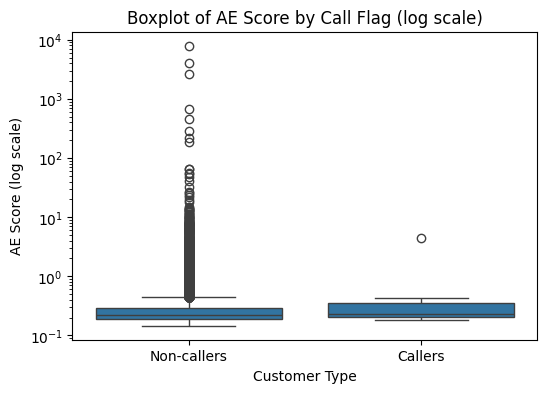

In [ ]:
# Create a label column for better axis readability
df_tsfresh_test['call_label'] = df_tsfresh_test['flag_call'].map({0: 'Non-callers', 1: 'Callers'})

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_tsfresh_test, x='call_label', y='ae_score')
plt.yscale('log')
plt.title('Boxplot of AE Score by Call Flag (log scale)')
plt.xlabel('Customer Type')
plt.ylabel('AE Score (log scale)')
plt.show()
